In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from uszipcode import SearchEngine
from IPython.display import Image
import time
import math

# Data Prep / Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression w/ l2 norm (Ridge)
from linear_reg import lr_gridsearch
from sklearn.linear_model import Ridge

# Random Forest
from random_forest import rf_train, feat_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Feature importance
from sklearn.inspection import permutation_importance

#nn
import torch  
import torch.nn as nn
import torch.nn.functional as F

import joblib

c:\Users\markm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualization and Metrics
## Load Models

In [54]:
class NN_configureable(nn.Module):
    '''
    Class for fully connected neural net.
    '''
    def __init__(self, input_dim, hidden_dim, hidden_layers):
        '''
        Parameters
        ----------
        input_dim: int
            input dimension (i.e., # of features in each example passed to the network)
        hidden_dim: int
            number of nodes in hidden layer
        '''
        super().__init__()
        #self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleDict()

        # Define input layer
        self.layers["input"] = nn.Linear(in_features = input_dim, out_features = hidden_dim)
        # Define hidden layers
        for i in range(self.hidden_layers):
            self.layers[f"hidden_{i}"] = nn.Linear(in_features = hidden_dim, out_features = hidden_dim)
        # Define output layer
        self.layers["output"] = nn.Linear(in_features = hidden_dim, out_features = 1)

    def forward(self, x):
        x = self.layers["input"](x)
        for i in range(self.hidden_layers):
            x = F.relu(self.layers[f"hidden_{i}"](x))

        return self.layers["output"](x)        
        

In [67]:
models = []
# Load the saved model from disk
# model_lr_old = joblib.load('Models/model_lr.joblib')
# model_rf_old = joblib.load('Models/model_rf.joblib')
model_lr = joblib.load('Models/model_lr2.joblib')
model_rf = joblib.load('Models/model_rf2.joblib')
model_nn = joblib.load('Models/model_nn.joblib')

#models = [model_lr, model_rf]
models = [model_lr, model_rf, model_nn]

## Load Data

In [59]:
# df_X_old = pd.read_csv('.\Data\df_X_OLD.csv')
# df_y_old = pd.read_csv('.\Data\df_y.csv')
# df_old = pd.read_csv('.\Data\df_all_features.csv')
df_X = pd.read_csv('.\Data\df_X_county.csv')
df_y = pd.read_csv('.\Data\df_y_county.csv')
df = pd.read_csv('.\Data\df_all_features_county.csv')

In [66]:
df_X

,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA
0,54669.0,38747.0,509844.0,167290.0,445.323695,12.66,3.378,0.0,0.0,0.0
1,54669.0,38747.0,649980.0,241889.0,821.038725,0.12,2.429,0.0,0.0,0.0
2,54669.0,38747.0,324682.0,127365.0,455.351666,12.66,3.378,0.0,0.0,0.0
3,54669.0,38747.0,69444.0,27199.0,2248.011733,0.12,2.429,0.0,0.0,0.0
4,54669.0,38747.0,715878.0,287756.0,4674.337363,0.12,2.429,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11084,54669.0,38747.0,13588.0,5798.0,9.570523,9.53,3.908,0.0,0.0,1.0
11085,54669.0,38747.0,11906.0,4866.0,7.258144,9.53,3.908,0.0,0.0,1.0
11086,54669.0,38747.0,22121.0,9714.0,25.026666,9.53,3.908,0.0,0.0,1.0
11087,54669.0,38747.0,19702.0,6035.0,10.708173,9.52,3.908,0.0,0.0,1.0


## Visualize By County

In [60]:
X = df_X.to_numpy()
y = df_y.to_numpy()

# only predict PHEV
y = y[:,0]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardize X
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_all = scaler.transform(X)

# extract list of feature names
features = df_X.columns.tolist()



In [63]:
# Set the model to evaluation mode
model.eval()

# Assuming you have the input data stored in a variable named 'X_test'
# Convert the input data to a PyTorch tensor
input_tensor = torch.tensor(X_test, dtype=torch.float32)

# Disable gradient calculation to improve inference performance
with torch.no_grad():
    # Forward pass through the model to obtain predictions
    output_tensor = model(input_tensor)

# Convert the output tensor to a NumPy array
predictions = output_tensor.numpy()

TypeError: Module.eval() takes 1 positional argument but 2 were given

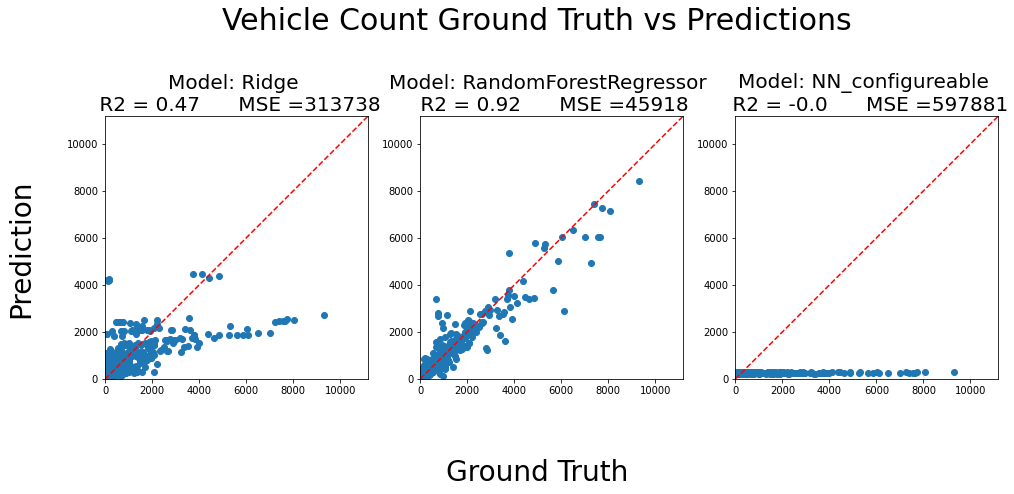

In [70]:
# Axis limits
x_min = 0
x_max = df_y['PHEV'].max()+500

# Define the number of rows and columns of subplots
num_cols = 3
num_rows = math.ceil(len(models)/num_cols)

# Create a figure and a grid of subplots with 2 columns
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 7))

# Flatten the axis array to simplify indexing
ax = ax.flatten()

for i, model in enumerate(models):
    try:
        y_hat = model.predict(X_test)
    except:


        # Set the model to evaluation mode
        model.eval()

        # Assuming you have the input data stored in a variable named 'X_test'
        # Convert the input data to a PyTorch tensor
        input_tensor = torch.tensor(X_test, dtype=torch.float32)

        # Disable gradient calculation to improve inference performance
        with torch.no_grad():
            # Forward pass through the model to obtain predictions
            output_tensor = model(input_tensor)

        # Convert the output tensor to a NumPy array
        y_hat = output_tensor.numpy()

    ax[i].scatter(y_test,y_hat)

    # Add the red reference line
    
    ax[i].plot([x_min, x_max], [x_min, x_max], 'r--')

    # Set the axis limits to be the same for both x and y
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(x_min, x_max)

    # Set the aspect ratio to be equal
    ax[i].set_aspect('equal', adjustable='box')

    # Get model type
    model_type = str(type(model))
    model_type = model_type.split(".")[-1]
    model_type = model_type[:-2]

    # calc R2 score
    # Compute the R-squared score
    r2 = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)

    # Set titles
    ax[i].set_title('Model: ' + model_type + ' \n R2 = ' + str(round(r2,2)) + 
                    '      MSE =' + str(int(mse)), fontsize=20)

# Add a common x-axis label
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=28)

# Add a common y-axis label
fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical', fontsize=28)

# Add a title to the entire plot
fig.suptitle('Vehicle Count Ground Truth vs Predictions', fontsize=30)

# Display the plot
plt.show()

# Percent Error by County
To Be Exported to Tableau


In [43]:
models = [model_rf]
#models = [model_rf, model_nn]

In [47]:
df

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8001,24.0
1,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8005,65.0
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
3,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8014,14.0
4,2017-01-01,Denver County,56.0,54669.0,38747.0,715878.0,287756.0,CO,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8031,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,Pend Oreille County,0.0,54669.0,38747.0,13588.0,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53051,2.0
11085,2018-10-01,Skamania County,0.0,54669.0,38747.0,11906.0,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53059,6.0
11086,2018-11-01,Pacific County,0.0,54669.0,38747.0,22121.0,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09,53049,2.0
11087,2019-01-01,Adams County,0.0,54669.0,38747.0,19702.0,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09,53001,1.0


In [48]:
df_y

,PHEV,BEV
0,22.0,24.0
1,61.0,65.0
2,63.0,167.0
3,7.0,14.0
4,56.0,94.0
...,...,...
11084,0.0,2.0
11085,0.0,6.0
11086,0.0,2.0
11087,0.0,1.0


In [51]:
df_exp = df[['Registration Date', 'fips','County', 'state', 'PHEV']]
# Combine strings from two columns with ', ' separator
df_exp['County, State'] = df['County'].str.cat(df['state'], sep=', ')

y = df_exp['PHEV']
for i, model in enumerate(models):
    y_hat = model.predict(X_all)
    
    error = (y-y_hat)/y * 100 # %

    df_exp['Y_hat ' +str(i)] = y_hat
    df_exp['Perc Error ' + str(i)] = error

df_exp.to_csv('./Data/df_error_vis.csv', index = False)

C:\Users\markm\AppData\Local\Temp\ipykernel_33652\1413102043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['County, State'] = df['County'].str.cat(df['state'], sep=', ')
C:\Users\markm\AppData\Local\Temp\ipykernel_33652\1413102043.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['Y_hat ' +str(i)] = y_hat
C:\Users\markm\AppData\Local\Temp\ipykernel_33652\1413102043.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

# Fix Vehicle Count per Month

In [ ]:
# convert the Unix timestamps to datetime format
df_X['Datetime'] = pd.to_datetime(df_X['Unix Time'], unit='s')

# format the datetime column as month-day-year
df_X['Date'] = df_X['Datetime'].dt.strftime('%m-%d-%Y')

xplt = df_X['Date']
yplt = df_y['Vehicle Count']

plt.plot(xplt,yplt, label='GT')
X_all = scaler.transform(X)
for model in models:
    y_hat_plt = []
    y_hat = model.predict(X_all)
    # for group in groups:
    #     datetime, indices = group
    #     y_hat_plt.append(sum(y_hat[indices]))
    model_type = str(type(model))
    model_type = model_type.split(".")[-1]
    model_type = model_type[:-2]
    plt.plot(xplt,y_hat_plt, label=model_type)

plt.legend()
plt.show()

In [ ]:
df_X['State'] = df['State']

# groupby and apply a lambda function to create a list of tuples where each tuple contains the group value and a list of indices for each item in the group
groups = df_X.groupby(['Datetime', 'State'])['Average EV Price'].apply(lambda x: ((x.name[0], x.name[1]), x.index.tolist())).tolist()

states = ['TX', 'NY', 'CO', 'WA']

for state in states:
    xplt = [x[0][0] for x in groups if x[0][1] == state]
    indices = [x[1] for x in groups if x[0][1] == state]
    yplt = []
    for idx in indices:
        yplt.append(sum(df_y.loc[idx, 'Vehicle Count']))

    plt.plot(xplt,yplt, label=state)
    
plt.legend()
plt.show()

yplt = []
for group in groups:
    datetime, indices = group
    yplt.append(sum(df_y.loc[indices, 'Vehicle Count']))

y_hat_plt = []
y_hat = model_rf.predict(X_all)
for group in groups:
    datetime, indices = group
    y_hat_plt.append(sum(y_hat[indices]))

plt.plot(xplt,y_hat_plt, label=model_type)

# OLD by ZIP

In [ ]:
# X = df_X_old.to_numpy()
# y = df_y_old.to_numpy()

# # split train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # standardize X
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# # extract list of feature names
# features = df_X_old.columns.tolist()

# models = [model_lr_old, model_rf_old]
# df_y_old['Vehicle Count'].max()
# # Axis limits
# x_min = 0
# x_max = df_y_old['Vehicle Count'].max()

# # Define the number of rows and columns of subplots
# num_cols = 2
# num_rows = math.ceil(len(models)/num_cols)

# # Create a figure and a grid of subplots with 2 columns
# fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))

# # Flatten the axis array to simplify indexing
# ax = ax.flatten()

# for i, model in enumerate(models):
#     y_hat = model.predict(X_test)

#     ax[i].scatter(y_test,y_hat)

#     # Add the red reference line
    
#     ax[i].plot([x_min, x_max], [x_min, x_max], 'r--')

#     # Set the axis limits to be the same for both x and y
#     ax[i].set_xlim(x_min, x_max)
#     ax[i].set_ylim(x_min, x_max)

#     # Set the aspect ratio to be equal
#     ax[i].set_aspect('equal', adjustable='box')

#     # Get model type
#     model_type = str(type(model))
#     model_type = model_type.split(".")[-1]
#     model_type = model_type[:-2]

#     # calc R2 score
#     # Compute the R-squared score
#     r2 = r2_score(y_test, y_hat)
#     mse = mean_squared_error(y_test, y_hat)

#     # Set titles
#     ax[i].set_title('Model: ' + model_type + ' \n R2 = ' + str(round(r2,2)) + 
#                     ' \n MSE =' + str(int(mse)))

# # Add a common x-axis label
# fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=14)

# # Add a common y-axis label
# fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical', fontsize=14)

# # Add a title to the entire plot
# fig.suptitle('Vehicle Count Ground Truth vs Predictions for Test Set', fontsize=16)

# # Display the plot
# plt.show()